# AI - MLP Project

## Function output prediction

### Ahmad Salimi - 97106013

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

In [447]:
class FunctionLearner:
    
    def __init__(self, function, data_size, train_domain):
        self.function = function
        self.X, self.y = self.make_random_dataset(data_size, train_domain)
        self.model = self.create_model()
    
    def make_random_dataset(self, size:int, domain):
        X = np.arange(domain[0], domain[1], (domain[1] - domain[0]) / size)
        # X = np.random.uniform(domain[0], domain[1], size)
        y = self.function(X).reshape(size,)
        return X, y
    
    def create_model(self):
        model = Sequential()
        model.add(Dense(10, input_dim=1, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1))

        opt = keras.optimizers.adam(learning_rate=.01)
        model.compile(optimizer=opt, loss='mse')
        return model
    
    def plot_result(self, x, xlim=None, ylim=None):
        x.sort()
        plt.figure(figsize=(25, 15))
        plt.plot(x, self.function(x), color='skyblue', label='original', linewidth=12, zorder=1)
        plt.scatter(self.X, self.y, color='green', label='train data', s=50, zorder=2)
        plt.plot(x, self.model.predict(x), color='red', label='predicted', linewidth=3, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def learn(self, epochs):
        return self.model.fit(self.X, self.y, batch_size=10, epochs=epochs, verbose=0, validation_split=0.1)

In [442]:
learner = FunctionLearner(lambda x: np.sin(x), 100, (-10, 10))

In [443]:
history = learner.learn()

In [444]:
history.history['loss'][-1]

0.0008501887544601535

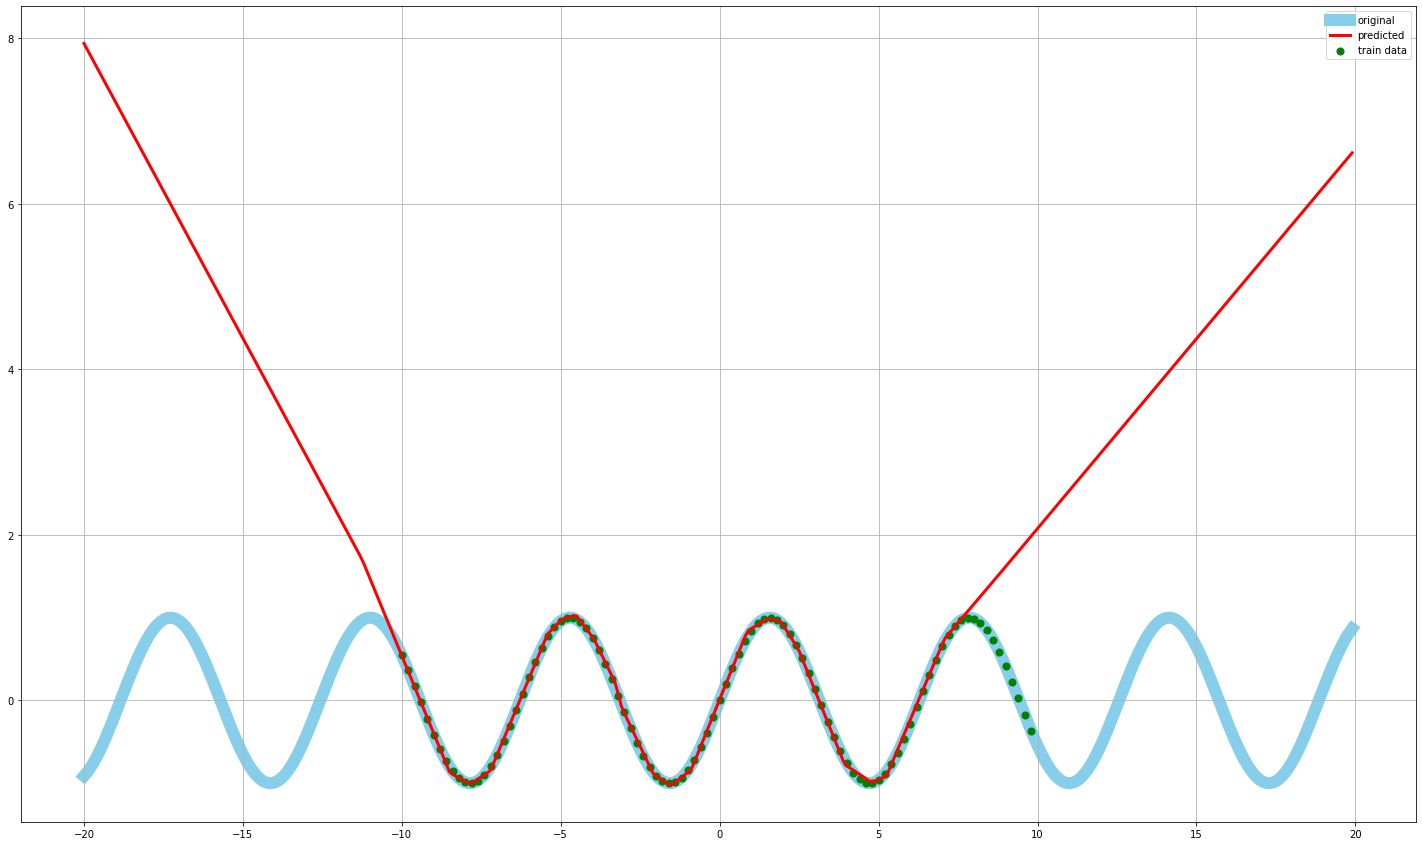

In [445]:
learner.plot_result(np.arange(-20, 20, 0.1))

In [463]:
learner = FunctionLearner(lambda x: 5 * x ** 3, 100, (-10, 10))

In [474]:
history = learner.learn(1000).history
history['loss'][-1]

323.76701249016656

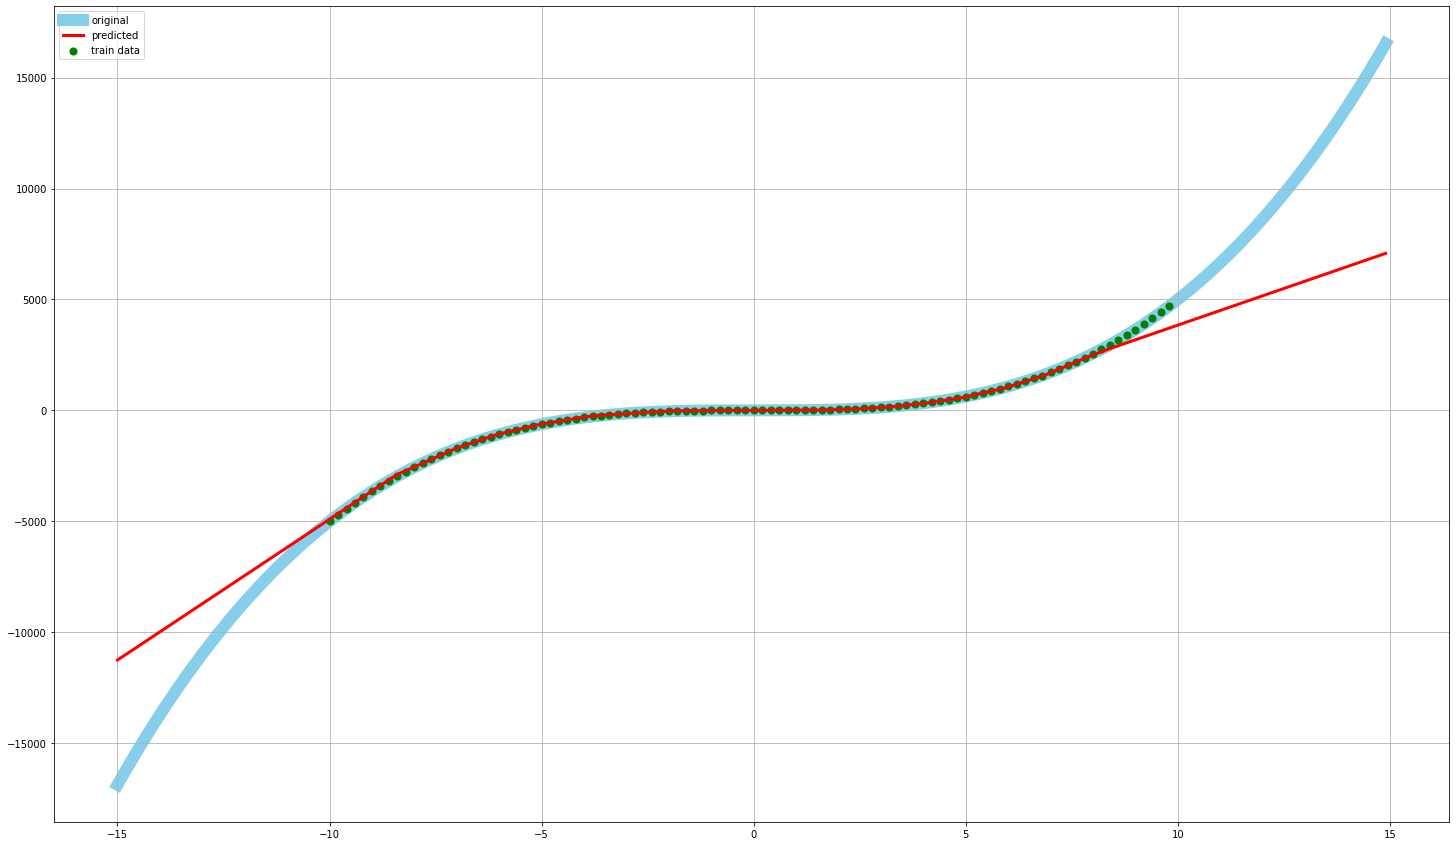

In [477]:
learner.plot_result(np.arange(-15, 15, .1))